## Hierarchical Model

In [48]:
import os
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reliability.Fitters import Fit_Weibull_2P
from reliability.Distributions import Weibull_Distribution
from cycler import cycler
plt.style.use('ggplot')

from scipy.stats import exponweib
import arviz as az

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 166 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 175 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 172 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 151 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 148 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 163 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 160 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 156 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 155 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 150 seconds.


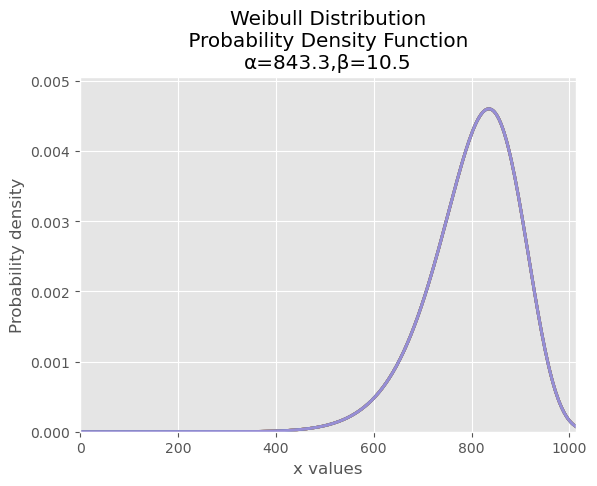

In [56]:
H_data = np.zeros((15, 4))
MLE_data = np.zeros((15, 4))
for idx, i in enumerate(np.arange(3, 31, 3)):

    dist = Weibull_Distribution(alpha=843.3, beta=10.5)
    dist.PDF(label=f'Batch 5', lw=2)
    samples = dist.random_samples(int(i))

    samples = pd.Series(samples).to_csv(f'data/batch_4_strengths.csv', index=False, header=False)

    data = []
    files = os.listdir('data')
    files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
    for j, file in enumerate(files):
        file_data = np.loadtxt('data/' + file, delimiter=',')
        file_data = np.column_stack((file_data, np.ones(file_data.shape[0]) * j))
        data.append(file_data)
    data = np.concatenate(data)

    strength = data[:, 0].flatten()
    batch = data[:, 1].astype(int).flatten()
    coords = {'batch': [str(n) for n in range(j+1)]}

    with pm.Model(coords=coords) as HWeib_model:
        batch_idx = pm.MutableData("batch_idx", batch, dims='obs_id')
        strength_obs = pm.MutableData("strength_obs", strength, dims='obs_id')

        global_alpha_mu = pm.Uniform("global_alpha_mu", lower=1, upper=25)
        global_beta_mu = pm.Uniform("global_beta_mu", lower=100, upper=2000)

        global_alpha_sigma = pm.Uniform("global_alpha_sigma", lower=0.5, upper=8)
        global_beta_sigma = pm.Uniform("global_beta_sigma", lower=5, upper=50)

        batch_alpha = pm.TruncatedNormal("batch_alpha", mu=global_alpha_mu, sigma=global_alpha_sigma, lower=0, dims="batch")
        batch_beta = pm.TruncatedNormal("batch_beta", mu=global_beta_mu, sigma=global_beta_sigma, lower=0, dims="batch")

        alpha = batch_alpha[batch_idx]
        beta = batch_beta[batch_idx]

        y = pm.Weibull("y", alpha=alpha, beta=beta, observed=strength_obs, dims="obs_id")

        idata = pm.sample(tune=15000, draws=10000, target_accept=0.99)

    res = az.summary(idata.posterior, stat_focus='mean')
    H_data[idx,0] = res.loc['batch_alpha[4]']['mean']
    H_data[idx,1] = res.loc['batch_alpha[4]']['sd']
    H_data[idx,2] = res.loc['batch_beta[4]']['mean']
    H_data[idx,3] = res.loc['batch_beta[4]']['sd']

    #save H_data to a csv
    np.savetxt('H_data_3.csv', H_data, delimiter=',')

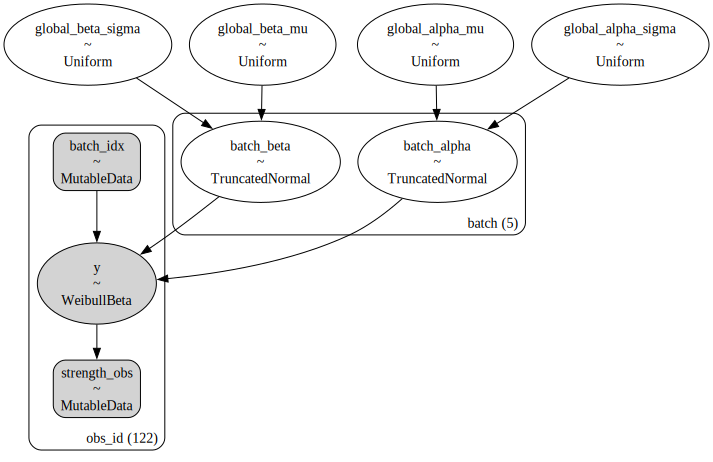

In [ ]:
# use every 10th sample for analysis
az.summary(idata.posterior, stat_focus='mean')


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_alpha_mu,11.366,1.679,8.417,14.799,0.014,0.01,16509,12544,1
global_beta_mu,855.481,15.733,825.082,885.639,0.107,0.075,21763,23391,1
global_alpha_sigma,2.356,1.668,0.5,5.77,0.019,0.013,8189,13002,1
global_beta_sigma,27.015,11.107,9.631,49.211,0.095,0.067,13044,16803,1
batch_alpha[0],10.544,1.288,8.051,12.9,0.008,0.006,23896,23013,1
batch_alpha[1],11.092,1.261,8.651,13.419,0.007,0.005,28546,26130,1
batch_alpha[2],12.65,1.684,9.655,15.854,0.013,0.009,17740,25348,1
batch_alpha[3],10.889,1.324,8.333,13.321,0.008,0.006,27247,24038,1
batch_alpha[4],12.038,2.894,6.82,17.829,0.021,0.016,19623,16822,1
batch_beta[0],862.792,13.801,837.079,889.162,0.081,0.057,28818,27595,1


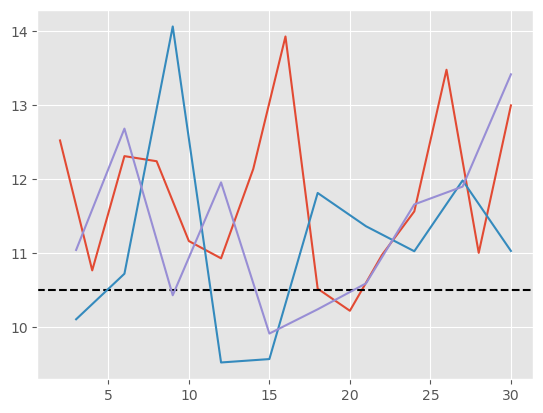

In [57]:
data = np.loadtxt('H_data_1.csv', delimiter=',')

plt.plot(np.arange(2, 31, 2), data[:,0], label='alpha')
plt.axhline(10.5, color='black', linestyle='--')

data = np.loadtxt('H_data_2.csv', delimiter=',')
plt.plot(np.arange(3, 31, 3), data[:,0], label='alpha')

data = np.loadtxt('H_data_3.csv', delimiter=',')
plt.plot(np.arange(3, 31, 3), data[:,0], label='alpha')

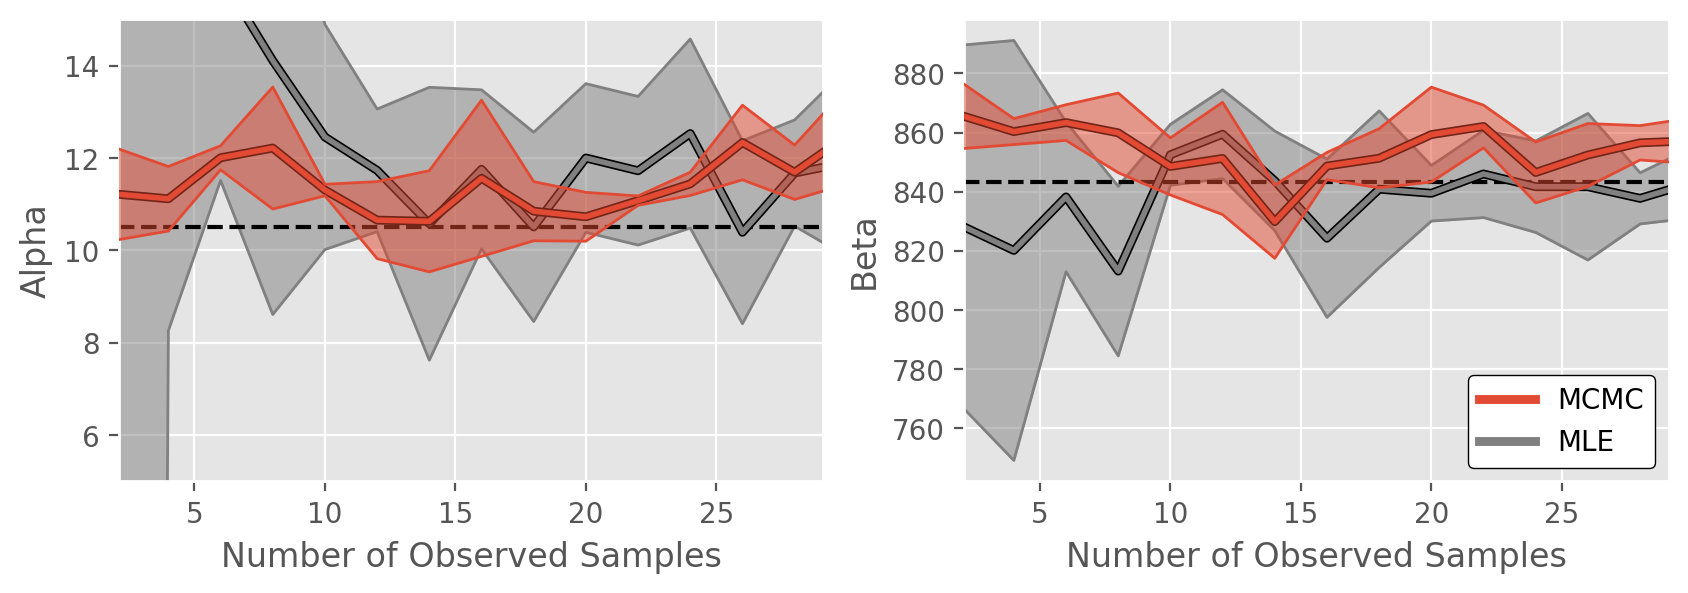

In [123]:
# load data and perform linear interpolation
from scipy.interpolate import interp1d
fig, ax = plt.subplots(ncols=2, figsize=(10, 3), dpi=200)
alpha = np.zeros((15, 3))
beta = np.zeros((15, 3))
for i in range(3):
    data = np.loadtxt(f'H_data_{i+1}.csv', delimiter=',')
    if i == 0:
        x = np.arange(2, 31, 2)
    else:
        x = np.linspace(2, 30, 10)
    y = data[:,0]
    f = interp1d(x, y, kind='linear')
    alpha[:,i] = f(np.arange(2, 31, 2))

    y = data[:,2]
    f = interp1d(x, y, kind='linear')
    beta[:,i] = f(np.arange(2, 31, 2))

ax[0].plot(np.arange(2, 31, 2), alpha.mean(axis=1), label=f'alpha_{i}', color='black', lw=3.2, zorder=100)
ax[0].plot(np.arange(2, 31, 2), alpha.mean(axis=1), label=f'alpha_{i}', lw=2, zorder=100)
ax[0].fill_between(np.arange(2, 31, 2), alpha.mean(axis=1) - alpha.std(axis=1), alpha.mean(axis=1) + alpha.std(axis=1), alpha=0.5, zorder=100)
ax[0].fill_between(np.arange(2, 31, 2), alpha.mean(axis=1) - alpha.std(axis=1), alpha.mean(axis=1) + alpha.std(axis=1), fc='None', ec='C0', lw=1, zorder=100)
ax[1].plot(np.arange(2, 31, 2), beta.mean(axis=1), color='black', lw=3.2, zorder=100)
ax[1].plot(np.arange(2, 31, 2), beta.mean(axis=1),  lw=2, zorder=100)
ax[1].fill_between(np.arange(2, 31, 2), beta.mean(axis=1) - beta.std(axis=1), beta.mean(axis=1) + beta.std(axis=1), alpha=0.5, zorder=100)
ax[1].fill_between(np.arange(2, 31, 2), beta.mean(axis=1) - beta.std(axis=1), beta.mean(axis=1) + beta.std(axis=1), fc='None', ec='C0', lw=1, zorder=100)


ax[0].axhline(10.5, color='black', linestyle='--')
ax[1].axhline(843.3, color='black', linestyle='--')

alpha= np.zeros((15, 5))
beta = np.zeros((15, 5))

for j in range(5):
    M_data = np.zeros((15, 4))
    for idx, i in enumerate(np.arange(2, 31, 2)):

        dist = Weibull_Distribution(alpha=843.3, beta=10.5)
        dist.PDF(label=f'Batch 5', lw=2, show_plot=False)
        samples = dist.random_samples(int(i))

        fit = Fit_Weibull_2P(failures=samples, show_probability_plot=False, print_results=False)
        M_data[idx] = [fit.alpha, fit.alpha_SE, fit.beta, fit.beta_SE]

        alpha[:,j] = M_data[:,2]
        beta[:,j] = M_data[:,0]

ax[0].plot(np.arange(2, 31, 2), alpha.mean(axis=1), label='alpha', color='k', lw=3.2)
ax[0].plot(np.arange(2, 31, 2), alpha.mean(axis=1), label='alpha', color='grey', lw=2)
ax[0].fill_between(np.arange(2, 31, 2), alpha.mean(axis=1) - alpha.std(axis=1), alpha.mean(axis=1) + alpha.std(axis=1), color='grey', alpha=0.5)
ax[0].fill_between(np.arange(2, 31, 2), alpha.mean(axis=1) - alpha.std(axis=1), alpha.mean(axis=1) + alpha.std(axis=1), fc='None', ec='grey', lw=1)

ax[1].plot(np.arange(2, 31, 2), beta.mean(axis=1), color='k', lw=3.2)
ax[1].plot(np.arange(2, 31, 2), beta.mean(axis=1), color='grey', lw=2)
ax[1].fill_between(np.arange(2, 31, 2), beta.mean(axis=1) - beta.std(axis=1), beta.mean(axis=1) + beta.std(axis=1),color='grey', alpha=0.5)
ax[1].fill_between(np.arange(2, 31, 2), beta.mean(axis=1) - beta.std(axis=1), beta.mean(axis=1) + beta.std(axis=1), fc='None', ec='grey', lw=1)

ax[0].set_ylim(5, 15)
ax[0].set_xlim(2.1, 29.1)
ax[1].set_xlim(2.1, 29.1)

ax[0].set_xlabel('Number of Observed Samples')
ax[1].set_xlabel('Number of Observed Samples')

ax[0].set_ylabel('Alpha')
ax[1].set_ylabel('Beta')

ax[1].plot([],[], label='MCMC', color='C0', lw=3.2)
ax[1].plot([],[], label='MLE', color='grey', lw=3.2)
ax[1].legend(facecolor='white', frameon=True, loc='lower right', framealpha=1, edgecolor='black')

plt.show()